# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for AdvXResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
import pdb

In [4]:
__version__

'1.0.56.dev0'

# 6D image test

In [5]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [6]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [7]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [8]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [9]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset parameters full dataset

In [10]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v1_20190714.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v1_20190714.csv', index_col=0)

In [11]:
df_train.head()

,path,experiment,sirna,multi,valid
0,HEPG2-01/Plate1/B03_s1,HEPG2-01,513,HEPG2-01 513,0
1,HEPG2-01/Plate1/B04_s1,HEPG2-01,840,HEPG2-01 840,0
2,HEPG2-01/Plate1/B05_s1,HEPG2-01,1020,HEPG2-01 1020,0
3,HEPG2-01/Plate1/B06_s1,HEPG2-01,254,HEPG2-01 254,0
4,HEPG2-01/Plate1/B07_s1,HEPG2-01,144,HEPG2-01 144,0


In [12]:
df_test.head()

,path,experiment
0,HEPG2-08/Plate1/B03_s1,HEPG2-08
1,HEPG2-08/Plate1/B04_s1,HEPG2-08
2,HEPG2-08/Plate1/B05_s1,HEPG2-08
3,HEPG2-08/Plate1/B06_s1,HEPG2-08
4,HEPG2-08/Plate1/B07_s1,HEPG2-08


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [13]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [14]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [15]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [16]:
## ResNet50pt
#sz, bs = 96, 8*46 # 77560MiB /  7952MiB

## XResNet50c
#sz, bs = 96, 8*46 # 7573MiB /  7952MiB
#sz, bs = 128, 8*52 # 7935MiB /  7952MiB
#sz, bs = 256, 8*13 # 7929MiB /  7952MiB
#sz, bs = 512, 8*3 # 7575MiB /  7952MiB

## XResNet50c AdaCos
sz, bs = 128, 8*50 # 7846MiB /  7952MiB

In [17]:
sz, bs

(128, 400)

In [18]:
# normal tfms
#tfms = get_transforms()

# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=color_augmentation())

In [19]:
# future transform mix?

### Full dataset

In [20]:
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [21]:
data

ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: EmptyLabelList
,,,,
Path: train

In [27]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [27]:
data.train_ds[0]

(Image6D (6, 128, 128), Category 513)

In [28]:
#data.classes

In [29]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

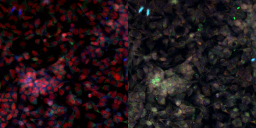

In [30]:
data.train_ds[0][0]

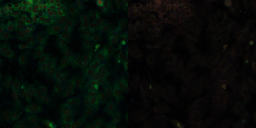

In [31]:
data.test_ds[0][0]

### Adversarial full dataset

In [32]:
data_a = (ImageList6D.from_df(df_train, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_train, path='train'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [282]:
data_a

ImageDataBunch;

Train: LabelList (33191 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (3324 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
267,768,632,86,1051
Path: train;

Test: None

In [283]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1138, 1138, ['RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07'])

In [284]:
data_a.batch_size

208

In [285]:
data_a.train_ds[0]

(Image6D (6, 128, 128), MultiCategory HEPG2-01;513)

In [286]:
#data_a.classes

In [287]:
data_a.train_ds[0][1], data_a.train_ds[0][1].data

(MultiCategory HEPG2-01;513,
 array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32))

In [288]:
data_a.train_ds[0][1].data.sum()

2.0

In [289]:
np.where(data_a.train_ds[0][1].data > 0.5)

(array([ 569, 1108]),)

In [290]:
[data_a.classes[j] for j in np.where(data_a.train_ds[0][1].data > 0.5)[0]]

['513', 'HEPG2-01']

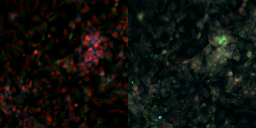

In [291]:
data_a.train_ds[0][0]

In [292]:
# DOES NOT WORK?
#data_a.train_ds[0][0].show()

# Model setup

## ResNet50 pretrained

In [84]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [85]:
# gives an error, because expects 6-channel weight in first conv layer
#learn.summary()

In [86]:
#learn.model

In [87]:
learn.model[0][0], type(learn.model[0][0])

(Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 torch.nn.modules.conv.Conv2d)

In [88]:
torch.nn.modules.conv.Conv2d is nn.Conv2d

True

In [89]:
p_dict = {pn: p for pn, p in learn.model[0][0].named_parameters()}

In [90]:
p_dict['weight'].shape, p_dict['weight'].requires_grad

(torch.Size([64, 3, 7, 7]), False)

In [91]:
old_weight = p_dict['weight'].detach()

In [92]:
old_weight.shape, old_weight.requires_grad

(torch.Size([64, 3, 7, 7]), False)

In [93]:
new_weight = torch.cat((old_weight, old_weight), dim=1)

In [94]:
new_weight.shape, new_weight.requires_grad

(torch.Size([64, 6, 7, 7]), False)

In [95]:
# replace first conv layer with a 6-channel version
learn.model[0][0] = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [96]:
learn.model[0][0]

Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [97]:
learn.model[0][0].weight.shape

torch.Size([64, 6, 7, 7])

In [98]:
# set new_weights to nn.Parameter and overwrite it in the conv layer
learn.model[0][0].weight = nn.Parameter(new_weight) # hand over requires_grad False?

In [99]:
# check if weight was loaded properly
assert torch.allclose(new_weight, learn.model[0][0].weight)

In [100]:
learn.model[0][0].weight.shape, learn.model[0][0].weight.requires_grad

(torch.Size([64, 6, 7, 7]), True)

In [101]:
# freeze input stage to only train output stage
#learn.freeze()
# DOES NOT WORK FOR INPUT CONV LAYER?

In [102]:
learn.model[0][0].weight.requires_grad = False

In [103]:
# check if layer is trainable and model looks fine
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 48, 48]         18,816     False     
______________________________________________________________________
BatchNorm2d          [64, 48, 48]         128        True      
______________________________________________________________________
ReLU                 [64, 48, 48]         0          False     
______________________________________________________________________
MaxPool2d            [64, 24, 24]         0          False     
______________________________________________________________________
Conv2d               [64, 24, 24]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
Conv2d               [64, 24, 24]         36,864     False     
___________________________________________________

In [104]:
learn.model(torch.randn(1,6,sz,sz).cuda()).shape

torch.Size([1, 1108])

In [105]:
learn.model(data.train_ds[0][0].data.unsqueeze(0).cuda()).shape

torch.Size([1, 1108])

## XResNet50

In [21]:
xresnet50c = XResNet(4, [3,4,6 ,3], c_in=6, c_out=1108)

In [22]:
#xresnet50c

In [23]:
xresnet50c(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 1108])

In [24]:
xresnet50c(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1108])

## AdvXResNet50

In [25]:
class AdvXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6, c_out=1108, c_out_a=33):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            #nn.Linear(block_szs[-1]*expansion, c_out),
            output_a(block_szs, expansion, c_out, c_out_a)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [26]:
# https://github.com/janfreyberg/pytorch-revgrad v0.1
from torch.autograd import Function

class RevGrad(Function):
    @staticmethod
    def forward(ctx, input_):
        ctx.save_for_backward(input_)
        output = input_
        return output

    @staticmethod
    def backward(ctx, grad_output):  # pragma: no cover
        grad_input = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output * ifnone(learn_a.opt.gr,0) # Gradient reversal !!!
            #print(learn_a.opt.gr)
        return grad_input


revgrad = RevGrad.apply

class RevGrad(Module):
    def __init__(self, *args, **kwargs):
        """
        A gradient reversal layer.
        This layer has no parameters, and simply reverses the gradient
        in the backward pass.
        """

        super().__init__(*args, **kwargs)

    def forward(self, input_):
        return revgrad(input_)

In [27]:
class output_a(Module):
    def __init__(self, block_szs, expansion, c_out, c_out_a):
        self.c_out, self.c_out_a = c_out, c_out_a
        
        self.AAP = nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        
        self.lin_label1 = nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion)
        self.lin_label2 = nn.Linear(block_szs[-1]*expansion, c_out)
        
        self.lin_domain1 = nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion)
        self.lin_domain2 = nn.Linear(block_szs[-1]*expansion, c_out_a)
        
        self.rg = RevGrad()
        
    def forward(self, x):
        x = self.AAP(x)
        x = self.flatten(x)
        
        x1 = self.lin_label2(act_fn(self.lin_label1(x)))
        x2 = self.lin_domain2(act_fn(self.rg(self.lin_domain1(x))))
        
        return torch.cat((x1, x2), dim=1)

In [28]:
advxresnet50c = AdvXResNet(4, [3,4,6 ,3], c_out_a=data_a.c-1108)

In [29]:
#advxresnet50c

In [30]:
advxresnet50c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1138])

In [31]:
advxresnet50c(data_a.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1138])

## AdaCosXResNet50

In [22]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, input, label=None):
        # normalize features
        x = F.normalize(input)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        if label is None:
            return logits
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / input.size(0)
            # print(B_avg)
            theta_med = torch.median(theta[one_hot == 1])
            self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        output = self.s * logits

        return output

In [23]:
class AdaCosXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6, c_out=1108, c_out_a=33):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion),
            AdaCos(block_szs[-1]*expansion, c_out),
            #nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [24]:
adacosxresnet50c = AdaCosXResNet(4, [3,4,6 ,3], c_in=6, c_out=1108)

In [25]:
#adacosxresnet50c

In [26]:
adacosxresnet50c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1108])

In [27]:
adacosxresnet50c(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1108])

# Full training

## Training AdaCosXResNet50

In [28]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [29]:
# #FP32
#learn = Learner(data, xresnet50c, metrics=[accuracy], callback_fns=[CSVLogger])

## FP16
learn = Learner(data, adacosxresnet50c, metrics=[accuracy], callback_fns=[CSVLogger]).to_fp16()

## FP16 + MixUp
#learn = Learner(data, xresnet50c, metrics=[accuracy], callback_fns=[CSVLogger]).to_fp16().mixup()

In [61]:
#learn.summary()

AdaCosXResNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 64, 64]         1,728      True      
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
ReLU                 [2048, 4, 4]         0          False     
______________________________________________________________________
Conv2d               [32, 64, 64]         9,216      True      
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
ReLU                 [2048, 4, 4]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         18,432     True      
________________________________________________

In [31]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [32]:
[p for p in learn.model[-1].named_parameters()]

[('W', Parameter containing:
  tensor([[-0.0056, -0.0207, -0.0046,  ...,  0.0036, -0.0048, -0.0167],
          [-0.0388, -0.0327, -0.0022,  ...,  0.0351,  0.0414,  0.0315],
          [ 0.0229,  0.0002,  0.0417,  ..., -0.0165, -0.0080,  0.0105],
          ...,
          [ 0.0079,  0.0185, -0.0026,  ..., -0.0374, -0.0068,  0.0089],
          [ 0.0374, -0.0076,  0.0010,  ...,  0.0291, -0.0035,  0.0130],
          [-0.0033, -0.0221, -0.0111,  ..., -0.0411,  0.0086, -0.0122]],
         device='cuda:0', dtype=torch.float16, requires_grad=True))]

### 128px AdaCos, extended tfms+CA

In [65]:
#learn.fit(1, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.006290,6.970033,0.001809,02:53


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 1.74E-06


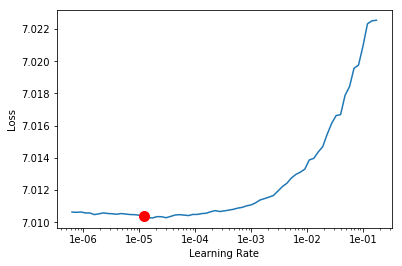

In [37]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [38]:
learn.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,7.011293,7.009511,0.000905,02:50
1,7.011594,7.006451,0.001551,02:53
2,7.008527,7.002557,0.001034,02:52
3,7.005580,7.001498,0.001422,02:53


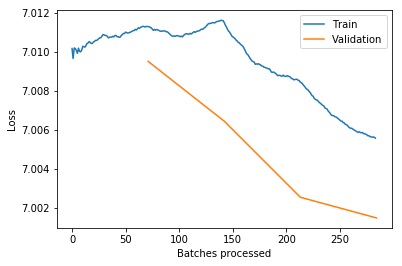

In [39]:
learn.recorder.plot_losses()

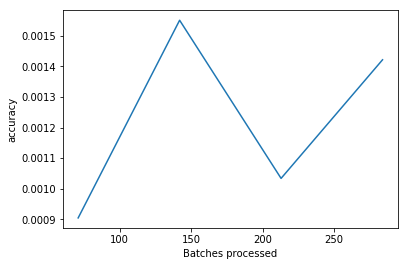

In [40]:
learn.recorder.plot_metrics()

In [38]:
#learn.recorder.plot_lr(show_moms=True)

In [41]:
learn.save('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e004_20190718', return_path=True)

PosixPath('train/models/adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e004_20190718.pth')

In [42]:
learn.load('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e004_20190718');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 1.91E-03


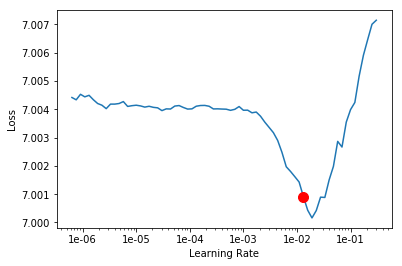

In [43]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [44]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.001134,6.980382,0.002843,02:50
1,6.961775,6.916833,0.002585,02:53
2,6.902768,6.868994,0.002197,02:53
3,6.860058,6.856921,0.001938,02:53
4,6.825450,6.845025,0.001809,02:52
5,6.807945,6.840609,0.001809,02:53
6,6.791889,6.847168,0.002326,02:52
7,6.783871,6.836812,0.002068,02:53


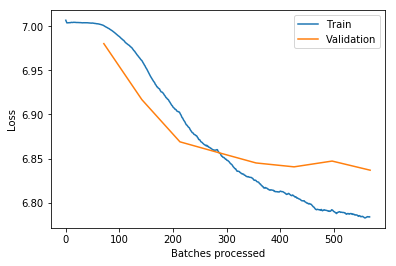

In [45]:
learn.recorder.plot_losses()

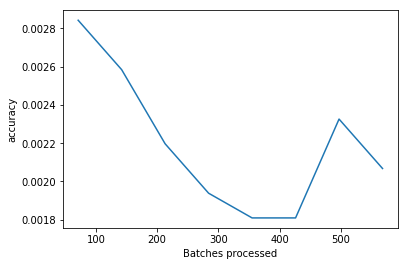

In [46]:
learn.recorder.plot_metrics()

In [47]:
learn.save('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e012_20190718', return_path=True)

PosixPath('train/models/adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e012_20190718.pth')

In [33]:
learn.load('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e012_20190718');

In [34]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=4)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_eXYZ_20190718_best')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 3.98E-05


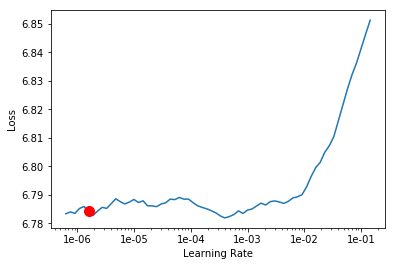

In [54]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
learn.fit(150, lr=1e-4, callbacks=[savem, redlr])

epoch,train_loss,valid_loss,accuracy,time
0,6.782987,6.840989,0.001422,02:52
1,6.780965,6.836513,0.001551,02:53
2,6.777259,6.833450,0.001292,02:53
3,6.775316,6.837117,0.001292,02:53
4,6.774997,6.837543,0.001551,02:53
5,6.773124,6.835165,0.001809,02:53
6,6.774576,6.834318,0.001422,02:54
7,6.771383,6.831526,0.001809,02:53
8,6.770814,6.831517,0.001551,02:53
9,6.767366,6.824751,0.002197,02:53


Better model found at epoch 0 with accuracy value: 0.0014215559931471944.
Better model found at epoch 1 with accuracy value: 0.0015507882926613092.
Better model found at epoch 5 with accuracy value: 0.0018092530081048608.
Better model found at epoch 9 with accuracy value: 0.002196950139477849.
Better model found at epoch 13 with accuracy value: 0.0025846471544355154.
Epoch 14: reducing lr to 2e-05
Epoch 19: reducing lr to 4.000000000000001e-06
Epoch 24: reducing lr to 8.000000000000002e-07
Epoch 29: reducing lr to 1.6000000000000006e-07
Better model found at epoch 34 with accuracy value: 0.002713879570364952.
Epoch 34: reducing lr to 3.2000000000000015e-08
Epoch 39: reducing lr to 6.4000000000000035e-09
Epoch 44: reducing lr to 1.2800000000000007e-09
Epoch 49: reducing lr to 2.5600000000000015e-10
Epoch 54: reducing lr to 5.1200000000000034e-11
Epoch 59: reducing lr to 1.0240000000000008e-11
Epoch 64: reducing lr to 2.0480000000000018e-12
Epoch 69: reducing lr to 4.096000000000004e-13


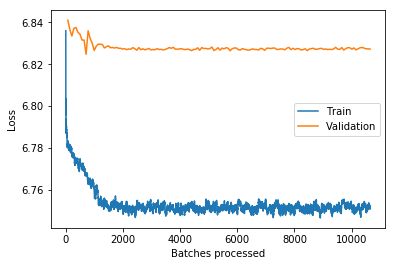

In [36]:
learn.recorder.plot_losses()

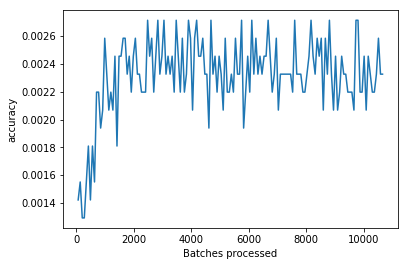

In [37]:
learn.recorder.plot_metrics()

In [38]:
learn.save('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e162_20190718', return_path=True)

PosixPath('train/models/adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e162_20190718.pth')

In [39]:
learn.load('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e162_20190718');

In [42]:
learn.load('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e046_20190718_best');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


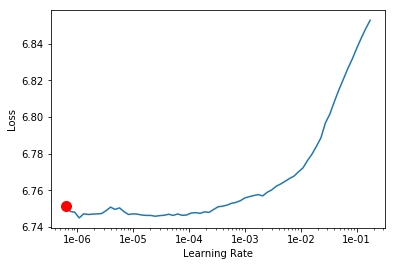

In [43]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [44]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.761999,6.836395,0.003102,02:51
1,6.774243,6.845889,0.001809,02:53
2,6.781439,6.858211,0.001422,02:53
3,6.781411,6.874105,0.001809,02:53
4,6.785233,6.884278,0.001163,02:53
5,6.793153,6.872223,0.002326,02:53
6,6.794763,6.893846,0.002326,02:54
7,6.794414,6.886840,0.002197,02:53


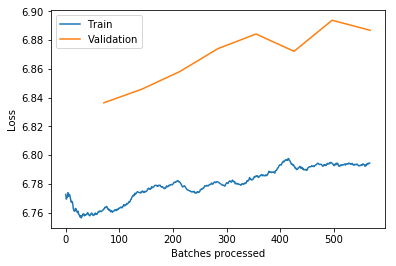

In [45]:
learn.recorder.plot_losses()

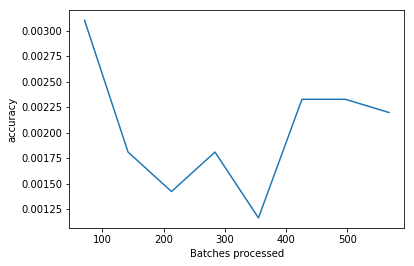

In [46]:
learn.recorder.plot_metrics()

In [49]:
learn.save('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e046+008_20190719', return_path=True)

PosixPath('train/models/adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e046+008_20190719.pth')

In [50]:
learn.load('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e046+008_20190719');

In [53]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=20)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_eXYZ_20190719_best')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 9.12E-08


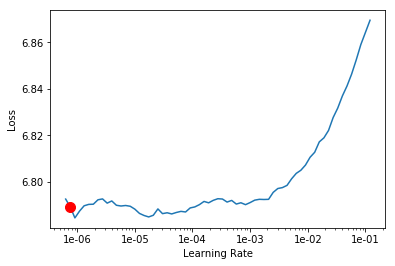

In [54]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [55]:
learn.fit(120, lr=1e-3, callbacks=[savem, redlr])

epoch,train_loss,valid_loss,accuracy,time
0,6.850223,6.942374,0.002455,02:51
1,6.868373,6.905226,0.001809,02:53
2,6.875950,6.931910,0.001680,02:53
3,6.889594,6.944979,0.001551,02:53
4,6.907676,6.894440,0.002585,02:53
5,6.920083,6.955552,0.001551,02:53
6,6.928136,6.972299,0.001422,02:53
7,6.939350,6.960063,0.002068,02:53
8,6.943675,6.954598,0.001422,02:53
9,6.953311,6.956423,0.001422,02:53


Better model found at epoch 0 with accuracy value: 0.0024554147385060787.
Better model found at epoch 4 with accuracy value: 0.0025846471544355154.
Epoch 25: reducing lr to 0.0002
Epoch 46: reducing lr to 4e-05


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



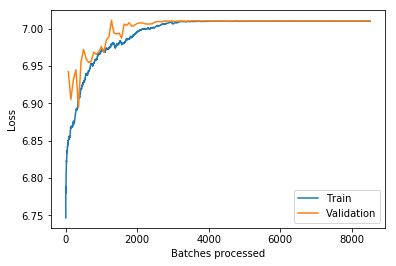

In [56]:
learn.recorder.plot_losses()

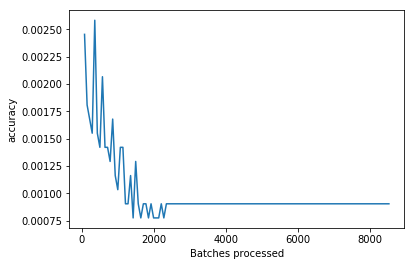

In [57]:
learn.recorder.plot_metrics()

In [58]:
learn.save('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e046+128_20190719', return_path=True)

PosixPath('train/models/adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e046+128_20190719.pth')

In [59]:
learn.load('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e046+128_20190719');

In [ ]:
# rename best model!

# Submission

## Get predicitions

In [54]:
model = 'xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e020-140_20190716_best'

In [55]:
learn.load(model)

Learner(data=ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: EmptyLabelList
,,,,
Path: train, model=XResNet(
  (0): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, e

In [56]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [71]:
# get TTA prediction of test dataset
learn.to_fp32();

Learner(data=ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: EmptyLabelList
,,,,
Path: train, model=XResNet(
  (0): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, e

In [72]:
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [78]:
# check length
len(preds)

19897

In [58]:
#preds

In [79]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [80]:
# get the names
preds_names = learn.data.test_ds.x.items

In [81]:
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]
# including sX
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [82]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds.argmax(dim=-1)})

In [83]:
df_preds.head()

,id_code,sirna
0,HEPG2-08_1_B03,18
1,HEPG2-08_1_B04,69
2,HEPG2-08_1_B05,324
3,HEPG2-08_1_B06,69
4,HEPG2-08_1_B07,222


In [84]:
df_preds.to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [85]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 81.4k/81.4k [00:06<00:00, 13.3kB/s]
Successfully submitted to Recursion Cellular Image Classification

## Sample submission

In [77]:
sample = pd.read_csv('sub/sample_submission.csv')

In [78]:
sample.shape

(19897, 2)

In [79]:
sample.head()

,id_code,sirna
0,HEPG2-08_1_B03,911
1,HEPG2-08_1_B04,911
2,HEPG2-08_1_B05,911
3,HEPG2-08_1_B06,911
4,HEPG2-08_1_B07,911


## Join submission with sample submission

In [81]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds.argmax(dim=-1)})

In [82]:
df_preds.shape

(19897, 2)

In [83]:
df_preds.head()

,id_code,sirna
0,HEPG2-08_1_B03,50
1,HEPG2-08_1_B04,69
2,HEPG2-08_1_B05,672
3,HEPG2-08_1_B06,69
4,HEPG2-08_1_B07,960


In [84]:
submission = pd.concat([sample['id_code'], df_preds], axis=1, sort=False)

In [85]:
submission.iloc[:,[0,-1]].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [86]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 70.3k/70.3k [00:07<00:00, 10.2kB/s]
Successfully submitted to Recursion Cellular Image Classification

In [ ]:
# WORKED FOR HIGHEST SCORE!

In [101]:
submission.iloc[:,[0,-1]].to_csv('results_test_20190716.csv', index=False)

In [102]:
!kaggle competitions submit -c recursion-cellular-image-classification -f results_test_20190716.csv -m "results_test_20190716"

100%|████████████████████████████████████████| 358k/358k [00:05<00:00, 61.5kB/s]
Successfully submitted to Recursion Cellular Image Classification

# Others

## Callback

In [ ]:
# https://docs.fast.ai/callback.html#callback

In [ ]:
# https://docs.fast.ai/callbacks.general_sched.html
def grl_scheduling(learn, n_cycles):
    '''Gradient reversal layer scheduling'''
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n).schedule_hp('grl_factor', grl, anneal=annealing_cos))
              for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    #learn. ??
    
    #if cycle_mult != 1:
    #    total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    #else: total_epochs = n_cycles * cycle_len
    #learn.fit(total_epochs)

In [ ]:
# https://docs.fast.ai/callback.html#OptimWrapper
# OptimWrapper needed with the 'grl' parameter?

In [ ]:
# Einfacher Callback mit nur 'on_train_begin'???

# Oder besser (?): monkey-patch optimizer mit 'grl' Variable
# und dann Adaptierung der 'grl_scheduling' Funktion!